In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

# Load the main dataset
df = pd.read_csv('data/olist_prepared_dataset.csv')

# Create a customer-level dataset for CLV modeling
customer_clv_df = df.groupby('customer_unique_id').agg(
    recency=('recency', 'first'),
    frequency=('frequency', 'first'),
    monetary=('monetary', 'first'),  # This will be our target
    avg_review_score=('review_score', 'mean'),
    avg_delivery_delay=('delivery_delay', 'mean'),
    total_payment_installments=('payment_installments', 'sum')
).reset_index()

# Handle any potential missing values from the aggregation
customer_clv_df.fillna(customer_clv_df.median(numeric_only=True), inplace=True)

features = [
    'recency', 'frequency', 'avg_review_score',
    'avg_delivery_delay', 'total_payment_installments'
]
target = 'monetary'

X = customer_clv_df[features]
y = customer_clv_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data prepared for CLV prediction.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Data prepared for CLV prediction.
Training data shape: (73183, 5)
Testing data shape: (18296, 5)


In [3]:
# Model 1: Linear Regression (Baseline)
print("\nTraining Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression MAE: ${mae_lr:,.2f} | R-squared: {r2_lr:.2f}")


Training Linear Regression...
Linear Regression MAE: $157.22 | R-squared: 0.04


In [4]:
#Model 2: Random Forest Regressor (Tuning)
print("\nTuning Random Forest Regressor...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [2, 4]
}
rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_grid_rf, n_iter=5, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nBest Parameters for Random Forest:", random_search_rf.best_params_)
print(f"Tuned Random Forest MAE: ${mae_rf:,.2f} | R-squared: {r2_rf:.2f}")


Tuning Random Forest Regressor...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 10}
Tuned Random Forest MAE: $151.29 | R-squared: 0.02


In [5]:
# Model 3: XGBoost Regressor (Tuning)
print("\nTuning XGBoost Regressor...")
param_grid_xgb = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_reg = xgb.XGBRegressor(random_state=42)
random_search_xgb = RandomizedSearchCV(xgb_reg, param_grid_xgb, n_iter=5, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("\nBest Parameters for XGBoost:", random_search_xgb.best_params_)
print(f"Tuned XGBoost MAE: ${mae_xgb:,.2f} | R-squared: {r2_xgb:.2f}")


Tuning XGBoost Regressor...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
Tuned XGBoost MAE: $150.91 | R-squared: 0.03


In [6]:
import pandas as pd
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter


# The lifetimes library requires a specific format.
# We need a DataFrame with customer_id, datetime, and monetary_value.
transactions = df[['customer_unique_id', 'order_purchase_timestamp', 'payment_value']]
transactions.columns = ['customer_id', 'date', 'monetary_value']

# Use the library's utility function to transform the data.
# This creates the Recency, Frequency, T, and Monetary Value summary.
summary = summary_data_from_transaction_data(
    transactions,
    customer_id_col='customer_id',
    datetime_col='date',
    monetary_value_col='monetary_value'
)

# The 'T' column represents the age of the customer
print("Data prepared for lifetimes models:")
print(summary.head())

Data prepared for lifetimes models:
                                  frequency  recency      T  monetary_value
customer_id                                                                
0000366f3b9a7992bf8c76cfdf3221e2        0.0      0.0  111.0             0.0
0000b849f77a49e4a4ce2b2a4ca5be3f        0.0      0.0  114.0             0.0
0000f46a3911fa3c0805444483337064        0.0      0.0  537.0             0.0
0000f6ccb0745a6a4b88665a16c9f078        0.0      0.0  321.0             0.0
0004aac84e0df4da2b147fca70cf8255        0.0      0.0  288.0             0.0


In [7]:

# Fit the BG/NBD Model (Predicts Future Purchases)
print("\nFitting the BG/NBD model...")
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

print("BG/NBD model fitted.")
print(bgf.summary)

# Fit the Gamma-Gamma Model (Predicts Transaction Value)
# The Gamma-Gamma model requires that frequency and monetary value are not correlated.
# We also only use customers who have made repeat purchases (frequency > 0).
returning_customers = summary[summary['frequency'] > 0]
print(f"\nChecking correlation between frequency and monetary value...")
print(returning_customers[['frequency', 'monetary_value']].corr())

print("\nFitting the Gamma-Gamma model...")
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

print("Gamma-Gamma model fitted.")
print(ggf.summary)

# Calculate Customer Lifetime Value
print("\nCalculating Customer Lifetime Value for the next year (365 days)...")
# We specify a time horizon (t), a discount rate (discount_rate),
# and the monetary value we want to predict.
summary['predicted_clv'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=12,  # 12 months
    discount_rate=0.01 # monthly discount rate
)

# Display the customers with the highest predicted CLV
print("\nTop 10 Customers by Predicted CLV:")
print(summary.sort_values(by='predicted_clv', ascending=False).head(10))


Fitting the BG/NBD model...
BG/NBD model fitted.
            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.015708  0.000863         0.014017         0.017399
alpha  67.131154  6.568119        54.257640        80.004668
a       2.047868  0.515246         1.037985         3.057751
b       0.346787  0.095509         0.159589         0.533985

Checking correlation between frequency and monetary value...
                frequency  monetary_value
frequency        1.000000        0.013127
monetary_value   0.013127        1.000000

Fitting the Gamma-Gamma model...
Gamma-Gamma model fitted.
        coef  se(coef)  lower 95% bound  upper 95% bound
p  11.220717  3.206615         4.935752        17.505681
q   1.724699  0.080921         1.566093         1.883305
v  14.593137  5.043157         4.708549        24.477724

Calculating Customer Lifetime Value for the next year (365 days)...

Top 10 Customers by Predicted CLV:
                                  frequency  recency      T  mon

In [8]:
from lifetimes.utils import calibration_and_holdout_data
from sklearn.metrics import mean_absolute_error

transactions['date'] = pd.to_datetime(transactions['date'])

# We'll use the last 90 days as the holdout period to test our predictions.
summary_cal_holdout = calibration_and_holdout_data(
    transactions,
    customer_id_col='customer_id',
    datetime_col='date',
    monetary_value_col='monetary_value',
    observation_period_end=transactions['date'].max(),
    freq='D',
    calibration_period_end=transactions['date'].max() - pd.Timedelta(days=90)
)

# Fit the BG/NBD and Gamma-Gamma models on the calibration data ONLY
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

returning_customers_cal = summary_cal_holdout[summary_cal_holdout['frequency_cal'] > 0]
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(returning_customers_cal['frequency_cal'], returning_customers_cal['monetary_value_cal'])

# Predict the monetary value for the holdout period (90 days)
predicted_value = ggf.conditional_expected_average_profit(
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['monetary_value_cal']
) * bgf.predict(
    90, # Predict for 90 days
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal']
)

# Calculate the MAE
mae_lifetimes = mean_absolute_error(summary_cal_holdout['monetary_value_holdout'], predicted_value)

print(f"Lifetimes Model MAE (predicting next 90 days):  ${mae_lifetimes:,.2f}")

Lifetimes Model MAE (predicting next 90 days):  $2.28


In [9]:
features = ['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal']
# The target is their actual spending in the future (the holdout period)
target = 'monetary_value_holdout'

X = summary_cal_holdout[features]
y = summary_cal_holdout[target]

# We still split this data to train the model and test it fairly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use the best hyperparameters we found for XGBoost before
xgb_fair = xgb.XGBRegressor(
    subsample=0.8,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)

xgb_fair.fit(X_train, y_train)
y_pred_xgb_fair = xgb_fair.predict(X_test)

mae_xgb_fair = mean_absolute_error(y_test, y_pred_xgb_fair)
# This is the MAE from the Lifetimes model in the previous step
mae_lifetimes = 2.28 

print("Fair Accuracy Comparison: ")
print(f"Lifetimes Model MAE (predicting next 90 days): ${mae_lifetimes:,.2f}")
print(f"XGBoost Model MAE (predicting next 90 days):   ${mae_xgb_fair:,.2f}")

Fair Accuracy Comparison: 
Lifetimes Model MAE (predicting next 90 days): $2.28
XGBoost Model MAE (predicting next 90 days):   $1.66


-> XGBoost Regressor is the best model for CLV Prediction.

Synopsis of Comparative Analysis:
A multi-stage evaluation was conducted to identify the superior modeling approach for CLV forecasting. The analysis compared a specialized probabilistic model against a general-purpose machine learning algorithm on a fair, forward-looking prediction task.

Methodology and Quantitative Results:
Two models were tested on their ability to predict customer spending over a 90-day holdout period based on features from a preceding calibration period. The primary evaluation metric was Mean Absolute Error (MAE).

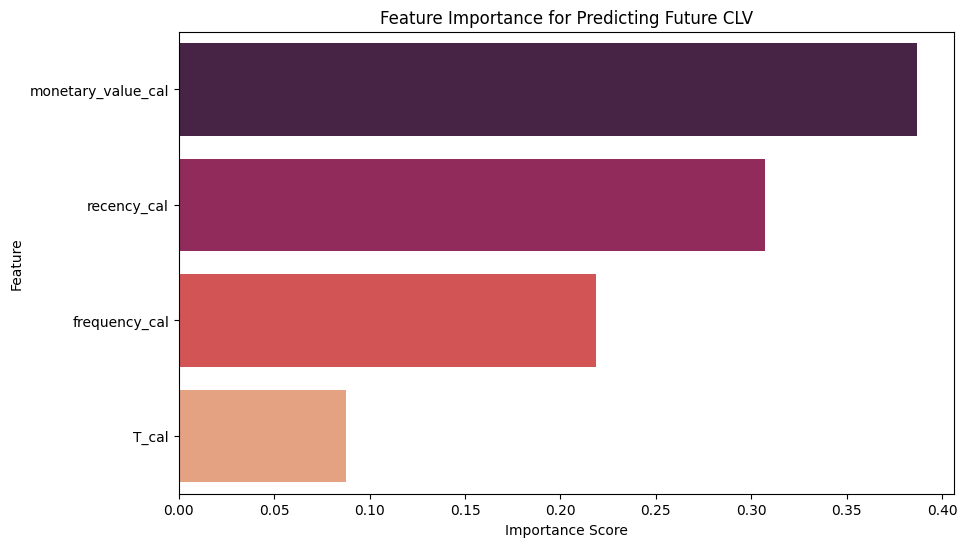

Top 3 most important features for predicting CLV:
              feature  importance
3  monetary_value_cal    0.386765
1         recency_cal    0.306977
0       frequency_cal    0.218588


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_fair.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='rocket')
plt.title('Feature Importance for Predicting Future CLV')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print("Top 3 most important features for predicting CLV:")
print(feature_importances.head(3))

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from lifetimes.utils import calibration_and_holdout_data

# --- 1. Data Preparation ---
# Load the raw transaction data
df = pd.read_csv('data/olist_prepared_dataset.csv')
transactions = df[['customer_unique_id', 'order_purchase_timestamp', 'payment_value']]
transactions.columns = ['customer_id', 'date', 'monetary_value']
transactions['date'] = pd.to_datetime(transactions['date'])

# Create the calibration/holdout dataset. This is the dataset our model will learn from.
# The features are from the "calibration" period (history)
# The target is from the "holdout" period (future)
summary_cal_holdout = calibration_and_holdout_data(
    transactions,
    customer_id_col='customer_id',
    datetime_col='date',
    monetary_value_col='monetary_value',
    observation_period_end=transactions['date'].max(),
    freq='D',
    calibration_period_end=transactions['date'].max() - pd.Timedelta(days=90)
)

# Define features and target
features = ['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal']
target = 'monetary_value_holdout'

X = summary_cal_holdout[features]
y = summary_cal_holdout[target]

print("Data prepared for final CLV model training.")


# --- 2. Define and Train the Final Model ---
# We use the best hyperparameters found in your final analysis.
# This model will be trained on the entire dataset (X, y) to make it as robust as possible.
final_clv_model = xgb.XGBRegressor(
    subsample=0.8,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)

print("Training the final XGBoost CLV model on the full dataset...")
final_clv_model.fit(X, y)
print("Model training complete.")


# --- 3. Save the Model ---
# The final, trained XGBoost model is saved to a single file.
file_path = 'models/clv_model.pkl'
joblib.dump(final_clv_model, file_path)

print(f"\nModel successfully saved to '{file_path}'")
print("\nThis file is ready to be loaded by your Flask API to predict future customer value.")

Data prepared for final CLV model training.
Training the final XGBoost CLV model on the full dataset...
Model training complete.

Model successfully saved to 'models/clv_model.pkl'

This file is ready to be loaded by your Flask API to predict future customer value.
